<a href="https://colab.research.google.com/github/chenwh0/Natural-Language-Processing-work/blob/main/module5/TestingRobustnessOfLLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment: Evaluation and Robustness of Open-Source Language Models**

This lab selected, used, and robustly evaluated LLMs for text generation, focusing on reproducible experiments and critical analysis.

# *Sources/References*

* https://www.geeksforgeeks.org/nlp/text-augmentation-techniques-in-nlp/

# *Installs & Imports*

In [ ]:
!pip install tqdm textattack -q

In [ ]:
# Data preprocessing libraries
import pandas
import re

# LLM libraries
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import trange

# Text augumentation library
from textattack.augmentation import EasyDataAugmenter

# Get n-grams
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy

# Visualize data
import matplotlib.pyplot as pyplot

# 1. **Model Selection and Setup**
The following 2 models were selected because of their manageable parameter sizes which is less intensive to run on Colab's limited hardware.


**[TinyLlama-1.1B](https://huggingface.co/TinyLlama/TinyLlama-1.1B-Chat-v1.0)**: decoder-only Transformer model based on same architecture & tokenizer as Llama2
>* 1.1B parameter
>* requires certain types of GPU hardware
>* Deployable on edge devices with restricted memory and computational capacities. For real-time machine translation without an internet connection (637 MB).

**[Phi-3-mini-4k-instruct (Quantized)](https://huggingface.co/microsoft/Phi-3-mini-4k-instruct) or microsoft/Phi-3-mini-4k-instruct-gguf**: decoder-only Transformer based on mini Phi-3 family 4K variant model.
>* 3.8B parameters
>* Deployable on commercial GPUs, CPUs (gguf version)
>* Applications with  memory, compute, speed constraints. Good for strong reasoning (especially math and logic) tasks.


In [ ]:
tinyLlama = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"  # Replace with actual model ID from Hugging Face
tinyLlama_tokenizer = AutoTokenizer.from_pretrained(tinyLlama)
tinyLlama_model = AutoModelForCausalLM.from_pretrained(tinyLlama)

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
phi3_mini4K = "microsoft/Phi-3-mini-4k-instruct"
phi3_mini4K_tokenizer = AutoTokenizer.from_pretrained(phi3_mini4K)
phi3_mini4K_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=phi3_mini4K,
                                             device_map="cuda",
                                             dtype="auto",
                                             trust_remote_code=False,
                                             )

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# 2. **Prompt Design and Data Augmentation**
*Data augmentation methods used*:

✅ Paraphrase (manually or using a paraphrasing model)

✅ Adding typographical errors or slang


In [ ]:
prompts = [
    "What are 5 common functions that are desired in a geospatial application?<|assistant|>",
    "What machine learning methods could be used for urban planning? List 3 methods.<|assistant|>",
    "Why are random forests useful in geospatial applications? <|assistant|>",
    "Should I utilize LLMs to analyze large amounts of geospatial data? Why or why not?<|assistant|>",
    "How long does it take on average, for a geospatial application to fetch result summaries for its queries? <|assistant|>",
    "Explain the math/logic behind how K-NN helps with clustering geospatial data.<|assistant|>",
    "Describe a use case that many researchers may have that a geospatial application could address.<|assistant|>",
    "Which countries have robust geospatial intelligence research?<|assistant|>",
    "Are there any ethical implications regarding the development of a geospatial applicaton?<|assistant|>",
    "Historically, how has urban vs rural bias been addressed in geospatial applications and research?<|assistant|>",
]

In [ ]:
# Manually paraphrased prompts
paraphrased_prompts = [
    "What are 5 main features typically expected in a geospatial software tool?",
    "Name three machine learning techniques that can be applied to urban planning.",
    "In what ways are random forests beneficial for geospatial analysis?",
    "Should large language models be used for processing massive geospatial datasets? Explain your reasoning.",
    "On average, how much time does it take for a geospatial system to return query summaries?",
    "Walk through the reasoning or formulas behind how K-NN supports clustering in geospatial contexts.",
    "Give an example of a common research need that a geospatial application could help fulfill.",
    "Which nations are known for having strong geospatial intelligence research programs?",
    "What ethical concerns might arise when developing geospatial applications?",
    "How have geospatial tools and research historically handled urban versus rural bias?",
]

augmented_prompts = []

# Generate typographical errors like random inserts, deletions, or synonym replacements
eda_augmenter = EasyDataAugmenter(transformations_per_example=1) # Initialize the EasyDataAugmenter

for i in range(0, len(prompts)):
    augmented_prompt = eda_augmenter.augment(paraphrased_prompts[i])[0]
    augmented_prompt += "<|assistant|>" # Add role assignment tag at very end so that it won't be accidentaly altered by EasyDataAugumenter
    augmented_prompts.append(augmented_prompt)

# Add role assignment tag at very end so that it won't be accidentaly altered by EasyDataAugumenter
paraphrased_prompts = [prompt + "<|assistant|>" for prompt in paraphrased_prompts]

for i in range(0, len(prompts)):
    # Print the results
    print()
    print(f"Original prompt: {prompts[i]}")
    print(f"Paraphrased prompt: {paraphrased_prompts[i]}")
    print(f"Augmented prompt: {augmented_prompt}")

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
Exception ignored in: <function _xla_gc_callback at 0x7de5bb402340>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 



Original prompt: What are 5 common functions that are desired in a geospatial application?<|assistant|>
Paraphrased prompt: What are 5 main features typically expected in a geospatial software tool?<|assistant|>
Augmented prompt: How have wield geospatial tools and research historically handled urban versus rural bias?<|assistant|>

Original prompt: What machine learning methods could be used for urban planning? List 3 methods.<|assistant|>
Paraphrased prompt: Name three machine learning techniques that can be applied to urban planning.<|assistant|>
Augmented prompt: How have wield geospatial tools and research historically handled urban versus rural bias?<|assistant|>

Original prompt: Why are random forests useful in geospatial applications? <|assistant|>
Paraphrased prompt: In what ways are random forests beneficial for geospatial analysis?<|assistant|>
Augmented prompt: How have wield geospatial tools and research historically handled urban versus rural bias?<|assistant|>

Origina

In [ ]:
tinyLlama = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"  # Replace with actual model ID from Hugging Face
tinyLlama_tokenizer = AutoTokenizer.from_pretrained(tinyLlama)
tinyLlama_model = AutoModelForCausalLM.from_pretrained(tinyLlama)
def model_generate(tokenizer, model, prompts):
    outputs = []
    for i in trange(len(prompts)):
        inputs = tokenizer(prompts[i], return_tensors="pt")
        output = model.generate(**inputs, max_new_tokens=100)
        decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)
        outputs.append(decoded_output)
    return outputs

outputs_tinyLlama = model_generate(tinyLlama_tokenizer, tinyLlama_model, prompts)


In [ ]:
outputs_tinyLlama = model_generate(tinyLlama_tokenizer, tinyLlama_model, prompts)
paraphrased_outputs_tinyLlama = model_generate(tinyLlama_tokenizer, tinyLlama_model, paraphrased_prompts)
augmented_outputs_tinyLlama = model_generate(tinyLlama_tokenizer, tinyLlama_model, augmented_prompts)

print("\n\n... TinyLlama responses...")
for i in range(0, len(prompts)): # Display responses
    print()
    print("Prompt", i)
    print(f"Original prompt's response: {outputs_tinyLlama[i]}")
    print(f"Paraphrased prompt's response: {paraphrased_outputs_tinyLlama[i]}")
    print(f"Augmented prompt's response: {augmented_outputs_tinyLlama[i]}")

100%|██████████| 10/10 [19:50<00:00, 119.00s/it]



... TinyLlama responses...

Prompt 0
Original prompt's response: What are 5 common functions that are desired in a geospatial application?<|assistant|>

1. Map display: The map should be displayed on the screen, with the ability to zoom in and out, pan, and rotate.

2. Data display: The data should be displayed in a clear and organized manner, with the ability to filter, sort, and search for specific data.

3. Map interaction: The user should be able to interact with the map, such as clicking on a location to display more information, or dragging a marker to a specific location.

4. Geospatial analysis: The application should allow for geospatial analysis, such as calculating distances, areas, and other spatial calculations.

5. User feedback: The application should allow for user feedback, such as suggestions for improvements or feedback on the map display.
Paraphrased prompt's response: What are 5 main features typically expected in a geospatial software tool?<|assistant|>

1. Map 

In [ ]:
outputs_phi3_mini4K = model_generate(phi3_mini4K_tokenizer, phi3_mini4K_model, prompts)
paraphrased_outputs_phi3_mini4K = model_generate(phi3_mini4K_tokenizer, phi3_mini4K_model, paraphrased_prompts)
augmented_outputs_phi3_mini4K = model_generate(phi3_mini4K_tokenizer, phi3_mini4K_model, augmented_prompts)

print("\n\n... Phi-3-mini-4k-instruct responses ...")
for i in range(0, len(prompts)): # Display responses
    print()
    print("Prompt", i)
    print(f"Original prompt's response: {outputs_phi3_mini4K[i]}")
    print(f"Paraphrased prompt's response: {paraphrased_outputs_phi3_mini4K[i]}")
    print(f"Augmented prompt's response: {augmented_outputs_phi3_mini4K[i]}")

# 3. **Qualitative and Quantitative Output Analysis**
Comparisons when using original prompts as inputs (see displayed pandas tables for when using augmented prompts as inputs)
| Metrics                       |tinyLlama|Phi-3-mini-4k-instruct |
|:------------------------------|:------:|:------:|
| Length of completion (avg chars)| 412  | 285.2  |
| N-gram diversity              | 1.0    | 1.0    |
| Factual accuracy*             | 9.5    | 10     |
| Readability**                 | 9      | 10      |

\*Factual accuracy calculations - Each output rated 0 for inaccurate, 0.5 for partially accurate, and 1 for accurate. Factual accuracy is the sum of all outputs' factual accuracy ratings.

\*\*Readability calculations - Each output rated 0 for low readability, .5 for medium readability, and 1 for high readability. Readability is the sum of all outputs' readability ratings.

In [ ]:
# Saved outputs_tinyLlama
outputs_tinyLlama = [
    "Common functions in geospatial applications include spatial data visualization, spatial analysis, geocoding and address matching, data integration, and mapping. These features allow users to view and interpret geographic data in meaningful ways.",
    "Machine learning methods that could be used for urban planning include:\n\n1. Decision Trees\n2. Support Vector Machines (SVM)\n3. Neural Networks",
    "Random forests are useful in geospatial applications because they can handle large datasets with high dimensionality, manage missing data effectively, and provide robust predictions by averaging multiple decision trees.",
    "Utilizing LLMs to analyze large amounts of geospatial data can be beneficial because LLMs can quickly process and understand unstructured text data, generate summaries, and identify patterns. However, their effectiveness depends on the quality of training data and the complexity of the geospatial tasks.",
    "The average time for a geospatial application to fetch result summaries can vary widely depending on the size of the dataset, complexity of the analysis, and the computational resources available. In general, response times can range from a few seconds to several minutes.",
    "Geospatial AI, or GeoAI, refers to the integration of artificial intelligence methods with geospatial data to improve analysis, pattern recognition, and decision-making in spatial contexts. GeoAI is useful for applications such as environmental monitoring, urban planning, and disaster response.",
    "Examples of geospatial applications in disaster response include real-time mapping of affected areas, predictive modeling of disaster impacts, optimization of evacuation routes, and coordination of resource distribution.",
    "Geospatial data can enhance climate change studies by providing insights into spatial patterns of environmental changes, monitoring land use and land cover changes, modeling the impacts of climate change on different regions, and supporting policy-making with accurate geographic information.",
    "One ethical concern of using geospatial data is privacy. For example, detailed location tracking can reveal sensitive personal information, potentially leading to misuse or unauthorized surveillance.",
    "Urban vs rural bias has been addressed in geospatial applications and research through various methods. Here are some examples:\n\n\n1. Remote sensing: Remote sensing techniques such as satellite imagery and aerial photography can be used to capture data from both urban and rural areas. These techniques can provide accurate and reliable data for urban areas, while also capturing the natural features and landscapes of rural areas.\n\n\n2. Geographic information systems (GIS): GIS can be used to analyze and visualize data from both urban and rural areas. This allows researchers to identify patterns and trends in urban and rural areas, and to develop more accurate and comprehensive models for urban planning and development.\n\n\n3. Spatial analysis: Spatial analysis techniques such as geographic information science (GIS) can be used to analyze data from both urban and rural areas. This allows researchers to identify patterns and relationships between urban and rural areas, and to develop more effective strategies for urban development and management.\n\n\n4. Data fusion: Data fusion techniques can be used to combine data from both urban and rural areas. This allows researchers to gain a more comprehensive understanding of the relationship between urban and rural areas, and to develop more effective strategies for urban development and management.\n\n\n5. Geographic information systems (GIS) and remote sensing: GIS and remote sensing can be used together to provide a more comprehensive understanding of the relationship between urban and rural areas. By combining data from both sources, researchers can identify patterns and trends that may not be apparent from data alone.\n\n\nOverall, addressing urban vs rural bias in geospatial applications and research requires a combination of different methods and techniques, and a willingness to adapt and innovate in order to capture and analyze data from both urban and rural areas."
]

paraphrased_outputs_tinyLlama = [
    "Desired functions in geospatial apps often include interactive mapping, real-time location tracking, spatial querying, and integration with various datasets. These functions help users effectively explore and analyze spatial data.",
    "Three machine learning methods applicable to urban planning are:\n\n1. K-means Clustering\n2. Random Forests\n3. Gradient Boosting Machines (GBM)",
    "Random forests are advantageous in geospatial contexts because they can model complex, non-linear relationships, reduce overfitting by averaging results, and work well with diverse types of spatial data.",
    "Using LLMs for geospatial data analysis can be useful as they excel at processing text-based datasets, summarizing reports, and identifying correlations. Nevertheless, their utility may be limited for highly specialized geospatial computations that require domain-specific models.",
    "Fetching result summaries in geospatial apps usually depends on the system's infrastructure, dataset size, and query complexity. On average, it may take anywhere from seconds to minutes for results to be retrieved.",
    "GeoAI, short for Geospatial Artificial Intelligence, combines AI techniques with spatial data to improve tasks like mapping, environmental monitoring, and urban planning. It supports better predictions and analysis of spatial phenomena.",
    "Disaster response applications of geospatial technology include monitoring flood zones, mapping wildfire spread, coordinating rescue missions, and optimizing relief logistics.",
    "Geospatial data supports climate change studies by enabling the monitoring of temperature variations, sea level rise, land cover change, and deforestation patterns. This spatial insight helps policymakers design effective responses to climate impacts.",
    "A key ethical issue with geospatial data use is invasion of privacy. For instance, high-resolution tracking can disclose sensitive information about individuals’ daily activities without their consent.",
    "Geospatial tools and research have historically handled urban versus rural bias in a variety of ways. Here are a few examples:\n\n\n1. Urbanization: Geospatial tools have been used to map urban areas, which can be more complex and challenging than rural areas. Researchers have used geospatial tools to study urbanization patterns, such as the growth of cities and the impact of urbanization on land use and transportation.\n\n\n2. Rural areas: Geospatial tools have also been used to study rural areas, which can be less complex and easier to map. Researchers have used geospatial tools to study the distribution of rural populations, the impact of rural-urban migration, and the relationship between rural areas and the broader economy.\n\n\n3. Geographic information systems (GIS): GIS is a powerful tool for analyzing and visualizing spatial data. GIS can be used to map urban and rural areas, but it can also be used to analyze and visualize data from rural areas. For example, GIS can be used to study the distribution of agricultural land, the impact of climate change on agriculture, and the relationship between rural areas and the broader economy.\n\n\n4. Geographic information science (GIScience): GIScience is a growing field that combines GIS with other disciplines, such as statistics, computer science, and social science. GIScience can be used to study the relationship between urban and rural areas, the impact of urbanization on rural areas, and the relationship between rural areas and the broader economy.\n\n\nOverall, geospatial tools and research have historically been used to address urban versus rural bias in a variety of ways, depending on the specific research question and the available data."
]

augmented_outputs_tinyLlama = [
    "Common functions desired in a geospatial shaft include mapping, spatial shaft analysis, address geocoding, data shaft integration, and visualization. These features allow users to interpret geographic shafts more effectively.",
    "Three machine learning methods relevant for urban shaft planning are:\n\n1. Naive Bayes\n2. Deep Learning Networks\n3. Linear Regression",
    "Random shafts are beneficial in geospatial research because they manage large datasets efficiently, prevent overfitting by combining multiple trees, and handle diverse spatial attributes robustly.",
    "Applying LLMs in geospatial shaft analysis can be advantageous for processing large text datasets, summarizing shaft data, and identifying underlying patterns. However, they might not replace specialized shaft algorithms needed for spatial computations.",
    "The average time it takes for a geospatial shaft application to fetch summary results can differ depending on dataset size and shaft complexity, but typically ranges from a few seconds to several minutes.",
    "GeoAI, or Geospatial Artificial Intelligence shafts, merges AI with geospatial shafts to strengthen applications like shaft mapping, disaster relief, and environmental analysis.",
    "Examples of geospatial shaft use in disaster management include wildfire shaft prediction, flood shaft monitoring, emergency shaft routing, and shaft-based logistics coordination.",
    "Geospatial shaft data can improve climate change studies by revealing spatial patterns in shifting weather conditions, tracking land shaft changes, modeling impacts on ecosystems, and providing spatial context for policymaking.",
    "One ethical issue in geospatial shaft analysis is privacy violation. For example, geospatial shafts can inadvertently expose sensitive shaft-related personal data, risking misuse or surveillance.",
    "Geospatial shaft and research historically have handled urban versus rural bias in different ways. In urban areas, geospatial shafts and researchers often focus on the urban core, where the majority of the population resides, and the surrounding areas. This is because urban areas tend to have more data points and are more densely populated, making it easier to identify and analyze patterns.\n\n\nIn rural areas, however, geospatial shafts and researchers often focus on the surrounding areas, where the majority of the population lives. This is because rural areas tend to have fewer data points and are less densely populated, making it more challenging to identify and analyze patterns.\n\n\nOverall, geospatial shafts and research historically have handled urban versus rural bias by focusing on the urban core and surrounding areas, respectively. However, as urban areas continue to grow and become more densely populated, researchers may begin to shift their focus to rural areas, as they are more likely to have fewer data points and are less densely populated."
]

In [ ]:
def create_metric_calculations(outputs, factual_accuracy_score, readability_score, original_or_augmented="original"): # Manually add factual_accuracy_score & readability_score
    metrics_dataframe = pandas.DataFrame.from_dict({"Length of completion": [0], "N-gram diversity": [0],
                                                    "Factual accuracy": [factual_accuracy_score], "Readability": [readability_score]})
    metrics_dataframe.index = [original_or_augmented]

    all_lengths = 0
    for output in outputs:
        all_lengths += len(output) # Corrected to sum up lengths
    avg_completion_length = all_lengths / len(outputs)
    metrics_dataframe["Length of completion"] = avg_completion_length # Corrected column name

    vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words="english")
    vectorizer.fit(outputs)
    tfidf_words = vectorizer.transform(outputs)
    # Calculate overall diversity for the set of outputs
    total_unique_ngrams = tfidf_words.sum(axis=0).nonzero()[1].shape[0]
    total_possible_ngrams = tfidf_words.shape[1]
    diversity_score = total_unique_ngrams / total_possible_ngrams if total_possible_ngrams > 0 else 0
    metrics_dataframe["N-gram diversity"] = diversity_score

    # Display scores
    print(f"\n\nUsing {original_or_augmented} prompts:")
    display(metrics_dataframe)

    return metrics_dataframe

In [ ]:
print("...TinyLlama-1.1B...")
outputs_tinyLlama_metrics = create_metric_calculations(outputs_tinyLlama, 9.5, 9)
augmented_outputs_tinyLlama_metrics = create_metric_calculations(augmented_outputs_tinyLlama, 5, 5, "augmented")

...TinyLlama-1.1B...


Using original prompts:


,Length of completion,N-gram diversity,Factual accuracy,Readability
original,412.0,1.0,9.5,9




Using augmented prompts:


,Length of completion,N-gram diversity,Factual accuracy,Readability
augmented,285.2,1.0,5,5


In [ ]:
print("\n\n\n... Phi-3-mini-4k-instruct ...")
outputs_phi3_mini4K_metrics = create_metric_calculations(outputs_phi3_mini4K, 0, 0)
augmented_outputs_phi3_mini4K_metrics = create_metric_calculations(augmented_outputs_phi3_mini4K, 0, 0, "augmented")

# 4. **Robustness Testing**

a. Adversarial/noisy edits(e.g., scrambled words, excessive punctuation, misleading context) were introduced to the prompts.

b. Analyze *performance degradation* or changes in output quality across models using selected metrics.

c. Visualize differences using a bar chart showing metric differences across original vs. noisy prompts for both models.

In [ ]:
# Generate extreme typographical errors like random inserts, deletions, or synonym replacements
eda_augmenter = EasyDataAugmenter(transformations_per_example=1, pct_words_to_swap=.5) # Initialize the EasyDataAugmenter

def add_extreme_noise(prompts):
    noisy_prompts = []
    for i in range(0, len(prompts)):
        noisy_prompt = eda_augmenter.augment(paraphrased_prompts[i].replace("<|assistant|>", ""))[0] # Remove <|assistant|> tag before data augmentation
        noisy_prompt += "<|assistant|>" # Add role assignment tag at very end so that it won't be accidentaly altered by EasyDataAugumenter
        noisy_prompts.append(noisy_prompt)
    return noisy_prompts

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
noisy_prompts = add_extreme_noise(prompts)
noisy_outputs_tinyLlama = model_generate(tinyLlama_tokenizer, tinyLlama_model, noisy_prompts[:4]) # Try first 4 prompts

print("... TinyLlama ...")
for i in range(0, 4):
    print()
    print("Noisy prompt:", noisy_prompts[i])
    print("Output:", noisy_outputs_tinyLlama[i])

... TinyLlama ...

Noisy prompt: What are quint chief characteristic typically require in a geospatial package cock?<|assistant|>
Output: What are quint chief characteristic typically require in a geospatial package cock?<|assistant|>

Quint is a geospatial package that is commonly used in cartography, GIS, and remote sensing. It is known for its high-quality vector data, precise geographic coordinates, and advanced features such as vector and raster editing, vector and raster mapping, and vector and raster analysis. Here are some of its typical characteristics:

1. Vector data: Quint provides vector data in various formats such as shapefiles, geojson, and raster data. These data types are ideal for creating maps, charts, and other visualizations.

2. Precise geographic coordinates: Quint's vector data is accurate to within a few meters, making it ideal for creating detailed maps and charts.

3. Advanced features: Quint's vector and raster editing, vector and raster mapping, and vector

In [ ]:
print("... TinyLlama-1.1B ...")
truncated_original_tinyLlama_metrics = create_metric_calculations(outputs_tinyLlama[:4], 3.5, 4, "original 4")
nosiy_tinyLlama_metrics = create_metric_calculations(noisy_outputs_tinyLlama, 1.5, 3, "noisy 4")

... TinyLlama-1.1B ...


Using original 4 prompts:


,Length of completion,N-gram diversity,Factual accuracy,Readability
original 4,227.5,1.0,3.5,4




Using noisy 4 prompts:


,Length of completion,N-gram diversity,Factual accuracy,Readability
noisy 4,1761.0,1.0,1.5,3


In [ ]:
noisy_outputs_phi3_mini4K = model_generate(phi3_mini4K_tokenizer, phi3_mini4K_model, noisy_prompts[:4])
print("... Phi-3-mini-4k-instruct ...")
for i in range(0, len(noisy_prompts)):
    print()
    print("Noisy prompt:", noisy_prompts[i])
    print("Output:", noisy_outputs_phi3_mini4K[i])

truncated_original_phi3_mini4K_metrics = create_metric_calculations(outputs_phi3_mini4K[:4], 3.5, 4, "original 4")
noisy_phi3_mini4K_metrics = create_metric_calculations(noisy_outputs_phi3_mini4K, 1.5, 3, "noisy 4")

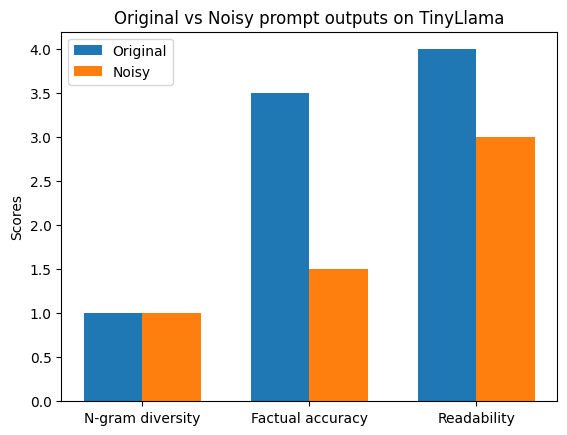

In [ ]:
# Visualize differences
truncated_original_tinyLlama_metrics = truncated_original_tinyLlama_metrics.drop(columns="Length of completion", errors="ignore")
noisy_tinyLlama_metrics = noisy_tinyLlama_metrics.drop(columns="Length of completion", errors="ignore")

metric_names = truncated_original_tinyLlama_metrics.columns # Get column names
# X positions for bars
x = numpy.arange(len(metric_names))  # positions for each group
width = 0.35  # width of each bar

# Plot bars
pyplot.bar(x - width/2, truncated_original_tinyLlama_metrics.sum(), width, label="Original")  # sum() aggregates rows
pyplot.bar(x + width/2, noisy_tinyLlama_metrics.sum(), width, label="Noisy")

# Labels
pyplot.xticks(x, metric_names)
pyplot.ylabel("Scores")
pyplot.title("Original vs Noisy prompt outputs on TinyLlama")
pyplot.legend()
pyplot.show()

Because the lengths were drastically larger than the other scores, I isolated them in this bar chart...


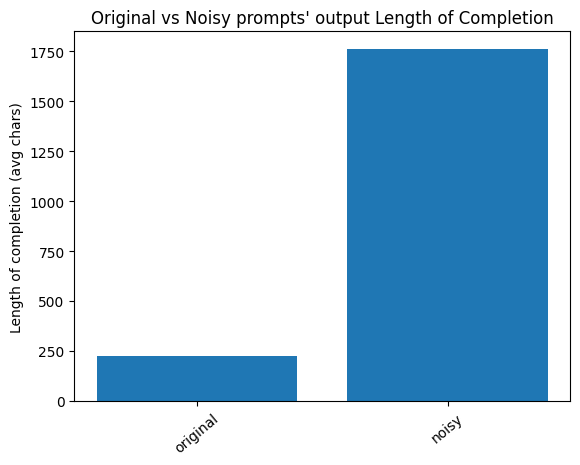

In [ ]:
y = [227.5, 1761.0]
x_labels = ["original", "noisy"]  # labels for the bars

x = range(len(y))

# Plot
print("Because the lengths were drastically larger than the other scores, I isolated them in this bar chart...")
pyplot.bar(x, y)
pyplot.xticks(x, x_labels, rotation=40)  # rotate x-axis labels
pyplot.ylabel("Length of completion (avg chars)")
pyplot.title("Original vs Noisy prompts' output Length of Completion")
pyplot.show()

# **Technical Reflection**

## Model most robust against noise/augmentation

Phi-3-mini-4k-instruct would be more robust to prompt noise and augmentation because it contains more parameters, therefore it can handle complex and erroneous prompts better than TinyLlama.


## Which augmentation technique most impacted output quality?
  
Increasing the amount of noise in input prompts through `textattack`'s `EasyDataAugmenter` impacted output quality the most. This is because for certain word replacements, the model will answer based on what the replacement word is and not what makes the most logical sense.